In [1]:
import os
import pickle
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.feature_extraction.text import TfidfVectorizer

# Обучение модели

In [2]:
with open('./data.csv', encoding='utf-8') as f_in:
    y = []
    texts = []
    for line in f_in:
        movie_id, sentiment, *text = line.strip('\n').split('\t')
        text = ' '.join(text)
        if sentiment == 'bad' or sentiment == 'good':
            y.append(1 if sentiment == 'good' else 0)
            texts.append(text)

In [3]:
%%time
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(texts)
print(X.shape)

(3680, 113678)
CPU times: user 606 ms, sys: 37.5 ms, total: 643 ms
Wall time: 642 ms


In [4]:
%%time
y_pred_cv = cross_val_predict(LogisticRegression(), X, y, cv=4, n_jobs=-1, verbose=True, method='predict_proba')
print('Cross-validated AUC: %.4f' % roc_auc_score(y, y_pred_cv[:,1]))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Cross-validated AUC: 0.8704
CPU times: user 37.6 ms, sys: 63.9 ms, total: 102 ms
Wall time: 930 ms


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.8s finished


In [5]:
%%time
L = LogisticRegression(solver='lbfgs', class_weight='balanced')
L.fit(X, y)

features = tfidf.get_feature_names()
features_with_weights = pd.DataFrame(zip(features, L.coef_[0]), columns=['feature', 'weight']).sort_values('weight')

CPU times: user 3.96 s, sys: 7.67 s, total: 11.6 s
Wall time: 901 ms


/home/maksim64/.local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
features_with_weights

,feature,weight
54495,ни,-2.939939
53984,нет,-2.812266
29775,зачем,-2.598898
12853,вообще,-2.440757
50533,не,-2.377328
...,...,...
61339,отлично,1.631123
53719,несмотря,1.672449
34502,каждый,1.812346
58831,он,2.006557


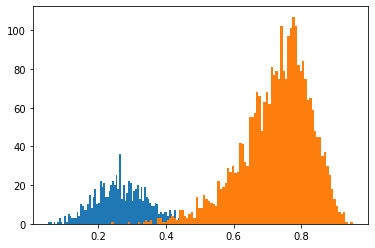

0.43434343434343436 0.9842391304347826


In [7]:
plt.hist(L.predict_proba(X[np.array(y) == 0])[:, 1], bins=100)
plt.hist(L.predict_proba(X[np.array(y) == 1])[:, 1], bins=100)
plt.show()

best_threshold, best_accuracy = 0.0, 0.0
for _ in np.linspace(0, 1, 100):
    correct_0 = np.sum(L.predict_proba(X[np.array(y) == 0])[:, 1] < _)
    correct_1 = np.sum(L.predict_proba(X[np.array(y) == 1])[:, 1] > _)
    accuracy_0 = (correct_0) / (np.sum(np.array(y) == 0))
    accuracy_1 = (correct_1) / (np.sum(np.array(y) == 1))
    accuracy = (correct_0 + correct_1) / (np.sum(np.array(y) == 0) + np.sum(np.array(y) == 1))
    if best_accuracy < accuracy:
        best_threshold, best_accuracy = _, accuracy
#     print("{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}\t".format(_, accuracy_0, accuracy_1, accuracy))
print(best_threshold, best_accuracy)

In [8]:
os.makedirs('./artefacts', exist_ok=True)
with open('./artefacts/logreg.pkl', 'wb') as f_out:
    pickle.dump(L, f_out)
with open('./artefacts/tf-idf.pkl', 'wb') as f_out:
    pickle.dump(tfidf, f_out)
with open('./artefacts/params.pkl', 'wb') as f_out:
    pickle.dump({'threshold': best_threshold}, f_out)

# Проверка работы на сервере

In [9]:
# export FLASK_APP="random_server" ; flask run

In [10]:
result = requests.post('http://127.0.0.1:5000/sentiment', json={'text': 'what is the answer?'})
print('response from server:', result.text)

response from server: {"score":0.6972330437779539,"sentiment":"positive"}

